<a href="https://colab.research.google.com/github/jhj030722/til/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch 19. 과대 적합을 막기 위한 방법들

# 손실 함수

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [3]:
# 모델을 만드는 함수 정의

def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(keras.layers.Dense(10, activation='softmax'))
  return model

if 구문의 역할

- model_fn 함수에 a_layer 매개변수로 케라스 층을 추가하면 은닉층 뒤에 하나의 층을 또 하나 추가하는 것

- a_layer 매개변수로 층을 추가하지 안ㅇㅎ고 단순하게 model_fn 함수 호출

In [4]:
model = model_fn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,500 (306.64 KB)

 Trainable params: 78,500 (306.64 KB)

 Non-trainable params: 0 (0.00 B)

이전과 동일하게 모델을 훈련하지만 fit 메서드의 결과를 history 변수에 담기

In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics= ['accuracy']) # metrics는 리스트 형태로
history = model.fit(train_scaled, train_target, verbose=0) # verbose : 훈련과정 출력을 조정 (에포크랑 비슷)

In [6]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


- keras는 epoch마다 손실을 계산함
- 정확도 : 컴파일 메서드에서 metrics 변수에 accuracy를 추가했기 때문에 history 속성에 포함되어 있음
- loss와 accuracy는 에포크마다 계산함 값이 순서대로 나열된 단순한 리스트

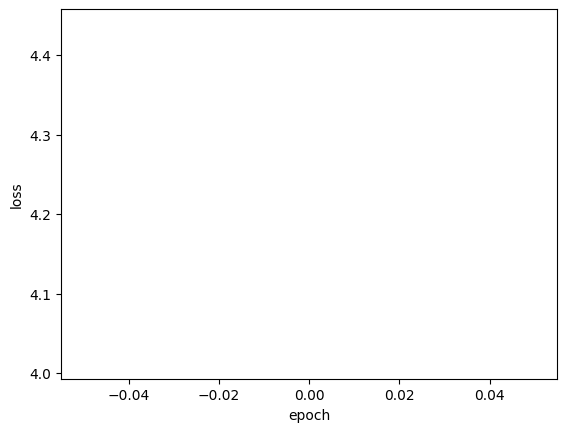

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

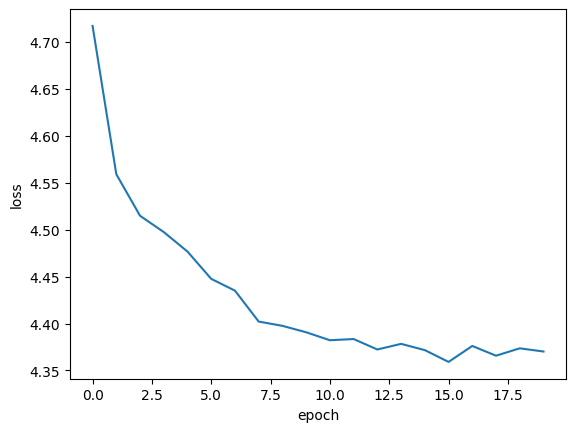

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 예상대로 손실이 잘 감소합니다.

# 검증 손실

- 4장) 확률적 경사 하강법을 사용했을 때 과소/과대적합과 epoch 사이의 관계
- 인공 신경망 모두 일종의 경사 하강법 사용 => 동일 개념 적용
- 에포크에 따른 과대적합과 과소적합을 평가하라면?
  => 훈련 세트에 대한 점수 뿐만 아니라 검증세트에 대한 점수도 필요

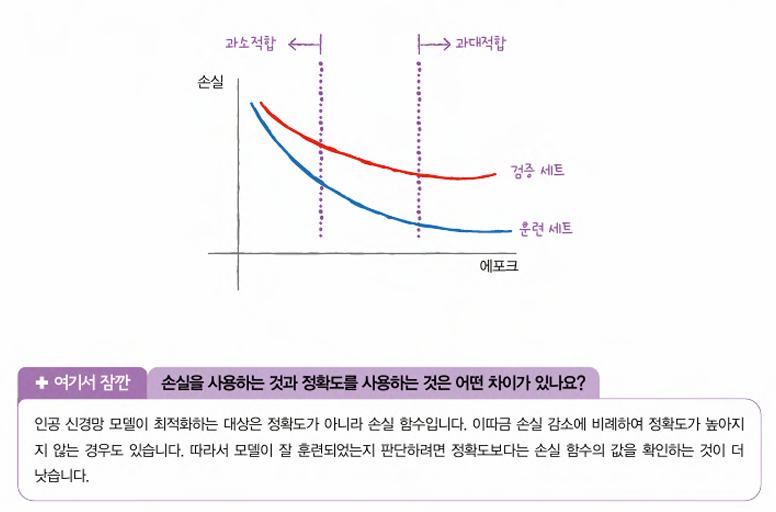

In [9]:
# validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달
# 에포크마다 검증 손실 계산하기 위해 fit() 메서드에 검증 데이터 전달

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [10]:
# 검증 세트에 대한 손실은 val_loss에 들어있고
# 정확도는 val_accuracy에 들어있음

print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


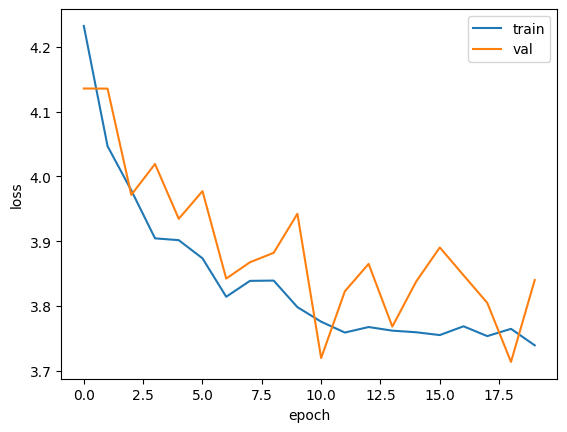

In [11]:
# 과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려서 비교

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

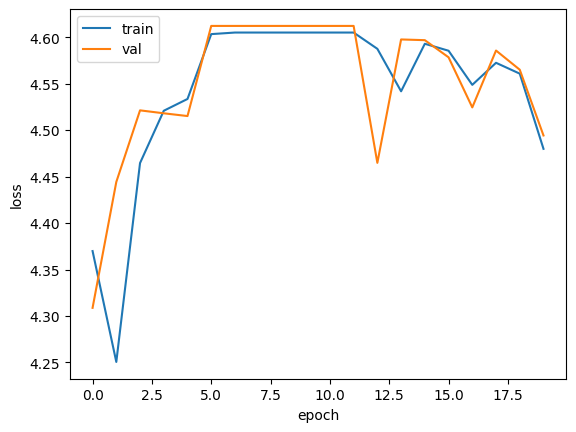

In [13]:
# 옵티마이저 파라미터를 조정하여 과대적합 완화시키기

# 기본: RMSprop
# Adam 옵티마이저로 바꿔보기

model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 이 경우에는 adam 옵티마이저가 기본 옵티마이저보다 loss가 크니까 잘 안맞는 옵티마이저인듯.

# 드롭아웃

- 훈련 과정에서, 층에 있는 일부 뉴런을 랜덤하게 꺼서(=뉴런의 출력을 0으로 만들어서) 과대적합을 막는 것

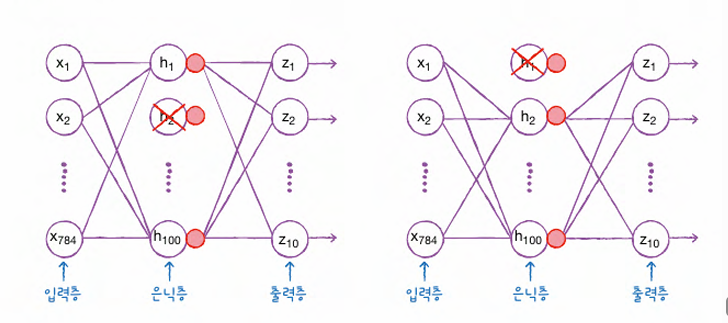


👉 드롭아웃이 왜 과대적합을 막을까?

- 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있음
- keras.layers 패키지 아래 dropout 클래스로 제공됨
- 층처럼 사용되지만 훈련되는 모델 파라미터는 없음

In [15]:
# model_fn 함수에 드롭아웃 객체를 전달하여 층을 추가하기
# 30% 정도 드롭 아웃

model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

- 드롭아웃은 훈련에만 사용
- 평가와 예측에 모델을 사용할 때는 드롭아웃 적용 x

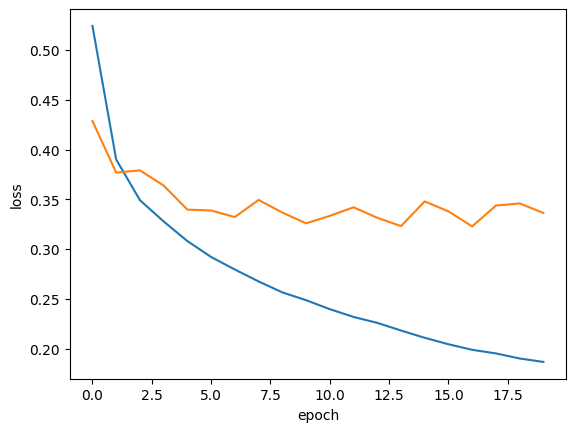

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 과대적합이 줄어듬
- 이 모델은 20번 에포크 동안 훈련했기 때문에 결국 다소 과대적합 되어있음
=> 과대적합되지 않은 모델 얻기 위해 에포크 횟수 10으로 하고 다시 훈련

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,validation_data=(val_scaled, val_target))
model.save_weights('model.weights.h5')  # ✅ .weights.h5로 끝나야 함

# save_weights() 메서드: 훈련된 모델의 파라미터를 저장

In [21]:
# save 메서드: 모델 구조와 모델 파라미터를 함께  저장하는 메서드

model.save('my_model.keras')  # ✅ 권장 방식

In [22]:
!ls -al *.h5

-rw-r--r-- 1 root root 974816 Mar 31 04:51 model.weights.h5
-rw-r--r-- 1 root root 977776 Mar 31 04:51 model.whole.h5


In [24]:
# 훈련하지 않은 새 모델 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터 읽어서 사용

model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- 이 모델의검증 정확도 확인
- 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환

- MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수: 12,000개 이므로 (12000,10)의 배열을 Predict()에서 반환

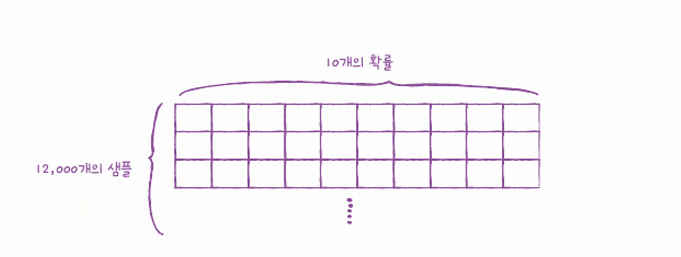

- 10개 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산
- evaluate 쓰지 않는 이유 : 이 메서드는 손실계산을 위해서 반드시 먼저 compile 메서드를 실행해야함. 여기에서는 새로운 데이터에 대해 정확도만 계산하는 상황이라고 가정

In [30]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1) #'배열에서 가장 큰 값의 인덱스를 반환하는 argmax 사용
# axis=-1은 배열의 마지막 차원을 따라 최댓값을 고름
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.887


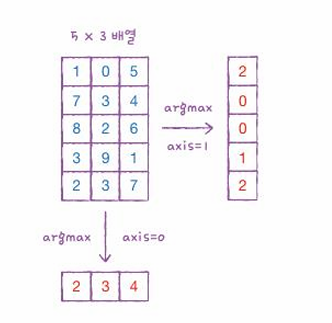

- axis = 1이면 **열** 을 따라 각 행의 최댓값의 인덱스 선택
- axis = 0이면 **행**을 따라 각 열의 최댓값의 인덱스를 선택

- 그다음 라인은 argmax()로 고른 인덱스(val_labels)와 타깃(val_target)을 비교
- 두 배열에서 각 위치의 값이 같으면 1이 되고 다르면 0이 됨 => 이를 평균하면 정확도가 됨

In [31]:
# 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도 출력하

model = keras.models.load_model('model.whole.h5') # load_model 함수는 모델 파라미터, 구조, 옵티마이저 상태 모두 복원 가능
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8857 - loss: 0.3432


[0.3404786288738251, 0.8870000243186951]

✅ 모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수는 없을까?

=> 케라스의 **콜백** 사용하기

# 콜백

- 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체

- keras.callbacks 패키지 아래에 있는 클래스들
- fit 메서드의 callbacks 매개변수에 리스트로 전달하여 사용

- ModelCheckpoint 콜백: 최상의 검증 점수를 만드는 모델을 저장


In [32]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- 모델이 훈련한 후에 `best-model.h5`에 최상의 검증 점수를 낸 모델이 저장됨
- 이제 이 모델을 `load_model()` 함수로 다시 읽어서 예측을 수행해보죠

In [33]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8892 - loss: 0.3389


[0.33146196603775024, 0.890999972820282]

- `ModelCheckpoint` 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해줌
- 검증 점수가 상승하기 시작하면 그 이후에는 과대 적합이 더 커지기 때문에 훈련을 계속할 필요가 없음

=> 이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있음

- 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 `조기 종료` 라고 부름 (에포크 횟수를 제한하는 역할)
  - keras의 **EarlyStopping** 콜백에서
  - `patience` 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수 지정
  - `restore_best_weights` 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

In [34]:
# EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용
#가장 낮은 검증 손실의 모델을 파일에 저장 => 검증 손실이 다시 상승할 때 훈련 중지 => 현재 모델의 파라미터를 최상의 파라미터로 되돌림

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
print(early_stopping_cb.stopped_epoch) # n번째 에포크에서 훈련이 중지되었다는 것을 의미
# patience가 2이므로 최상의 모델은 5번째 에포크

6


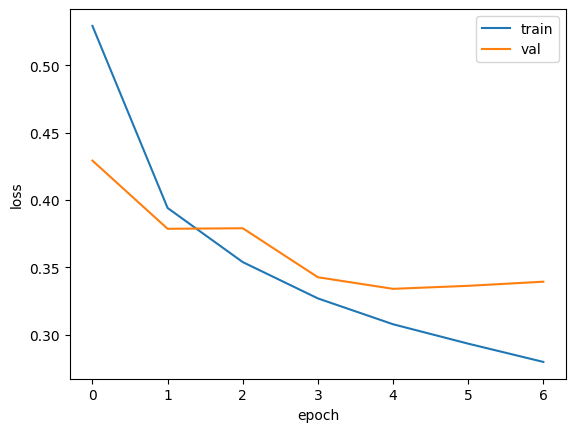

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [37]:
# 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능 확인
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8796 - loss: 0.3346


[0.33400267362594604, 0.8813333511352539]